 #                                Movie Recommender System

In [17]:

# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os, re, pickle, ast

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

# Visualization style
sns.set_style('darkgrid')


####This cell loads all required Python libraries for data manipulation, NLP processing, similarity computation, collaborative filtering, and visualization.

##Load Datasets

In [18]:

# Load Movies & Credits Data

movies = pd.read_csv('5000movies.csv')
credits = pd.read_csv('5000credits.csv')

# Merge movies and credits
tmdb_movies = movies.merge(credits, on='title')
tmdb_movies.head()


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


####Loaded two datasets and merged them based on the movie title. This provides enriched movie information including cast and crew.

##Initial Data Exploration

In [19]:
tmdb_movies.info()
tmdb_movies.isnull().sum()
tmdb_movies.duplicated().sum()
tmdb_movies['original_language'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

,count
original_language,
en,4510
fr,70
es,32
zh,27
de,27
hi,19
ja,16
it,14
ko,12


####Checked dataset shape and info, Counted missing values and duplicates, Explored language distribution

##Feature Selection

In [20]:
# Keep relevant features for content-based recommender
movies1 = tmdb_movies[['id','title','genres','keywords','overview','cast','crew']]
movies1.dropna(inplace=True)
movies1.duplicated().sum()


np.int64(0)

####Filtered only the necessary columns for building a hybrid recommendation system and removed missing values.

##Data Cleaning and Conversion

In [21]:
# Convert genres, keywords, cast, crew to lists
def converter(obj):
    return [i['name'] for i in ast.literal_eval(obj)]

movies1['genres'] = movies1['genres'].apply(converter)

def convert3(text):
    return [i['name'] for i in ast.literal_eval(text)[:3]]

movies1['cast'] = movies1['cast'].apply(convert3)
movies1['keywords'] = movies1['keywords'].apply(converter)

def fetch_director(text):
    return [i['name'] for i in ast.literal_eval(text) if i['job']=='Director']

movies1['crew'] = movies1['crew'].apply(fetch_director)

# Clean whitespace
for col in ['genres','cast','keywords','crew']:
    movies1[col] = movies1[col].apply(lambda x: [i.replace(" ","") for i in x])


####Converted stringified JSON to Python lists
####Kept top 3 cast members

####Extracted directors from crew

####Removed whitespace for uniformity


##Create Combined Tags

In [22]:
# Combine features for NLP processing
movies1['tags'] = movies1['genres'] + movies1['keywords'] + movies1['overview'].apply(lambda x:x.split()) + movies1['cast'] + movies1['crew']

# Final dataset for NLP
movies2 = movies1[['id','title','tags']]
movies2['tags'] = movies2['tags'].apply(lambda x: " ".join(x).lower())


####Created a single column combining all textual features (genres, cast, crew, overview, keywords) to use for content-based similarity.


##Text Preprocessing

In [23]:
# Stemming
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def stem(text):
    return " ".join([ps.stem(i) for i in text.split()])

movies2['tags'] = movies2['tags'].apply(stem)


####Applied stemming to reduce words to root forms, improving NLP similarity computation.

##Content-based Similarity

In [24]:
cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(movies2['tags']).toarray()
similarity = cosine_similarity(vectors)

# Example recommendation
def recommend(movie):
    index = movies2[movies2['title']==movie].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    for i in distances[1:6]:
        print(movies2.iloc[i[0]].title)

recommend("Avatar")


Aliens vs Predator: Requiem
Aliens
Falcon Rising
Independence Day
Titan A.E.


####Converted tags to vectorized form and Calculated cosine similarity for content-based recommendations

##Save Processed Files

In [27]:
pickle.dump(movies2, open('movie_list.pkl','wb'))
pickle.dump(similarity, open('similarity.pkl','wb'))


##Collaborative Filtering (SVD)

In [29]:
# ==============================
# 📌 Collaborative Filtering (CF) with SVD
# ==============================

import re
from difflib import get_close_matches
from scipy.sparse.linalg import svds

# Step 1: Clean titles for mapping
def clean_title(t):
    if pd.isna(t): return ""
    t = re.sub(r'\(\d{4}\)', '', str(t))  # remove year e.g. (1995)
    t = re.sub(r'[^a-z0-9 ]', ' ', t.lower())
    t = re.sub(r'\s+', ' ', t).strip()
    return t

movies_ml['title_clean'] = movies_ml['title'].apply(clean_title)
movies2['title_clean']   = movies2['title'].apply(clean_title)

# Step 2: Try exact merge mapping
map_df = movies_ml[['movieId','title_clean']].merge(
    movies2[['id','title_clean']], on='title_clean', how='inner'
).drop_duplicates(subset=['movieId'])

mapping = map_df.set_index('movieId')['id'].to_dict()
ratings['tmdb_id'] = ratings['movieId'].map(mapping)

print("✅ Exact matches found:", ratings['tmdb_id'].notna().sum(), "/", len(ratings))

# Step 3: Fallback fuzzy matching if too few matches
if ratings['tmdb_id'].notna().sum() < 100:  # threshold can be adjusted
    print("⚠️ Too few exact matches, applying fuzzy matching...")
    title_map = {}
    for _, row in movies_ml.iterrows():
        match = get_close_matches(row['title_clean'], movies2['title_clean'].tolist(), n=1, cutoff=0.7)
        if match:
            tmdb_id = movies2.loc[movies2['title_clean']==match[0], 'id'].iloc[0]
            title_map[row['movieId']] = tmdb_id
    ratings['tmdb_id'] = ratings['movieId'].map(title_map)

print("✅ Final mapped ratings:", ratings['tmdb_id'].notna().sum(), "/", len(ratings))

# Step 4: Drop NaN and duplicates
ratings_mapped = ratings.dropna(subset=['tmdb_id']).copy()
ratings_mapped['tmdb_id'] = ratings_mapped['tmdb_id'].astype(int)

if ratings_mapped.empty:
    raise ValueError("⚠️ Still no mapped ratings. Check MovieLens ↔ TMDB title formats.")

ratings_mapped = ratings_mapped.drop_duplicates(subset=['userId','tmdb_id'], keep='last')

# Step 5: Build train/test (leave-one-out per user)
user_counts = ratings_mapped['userId'].value_counts()
eligible_users = user_counts[user_counts >= 2].index.tolist()

if 'timestamp' in ratings_mapped.columns:
    idx_test = ratings_mapped[ratings_mapped['userId'].isin(eligible_users)].groupby('userId')['timestamp'].idxmax()
else:
    idx_test = ratings_mapped[ratings_mapped['userId'].isin(eligible_users)].groupby('userId').sample(n=1, random_state=42).index

test_df = ratings_mapped.loc[idx_test].copy().reset_index(drop=True)
train_df = ratings_mapped.drop(index=idx_test).reset_index(drop=True)

print("Train ratings:", len(train_df), " | Test ratings:", len(test_df))

# Step 6: Create user-item matrix
train_df = train_df.groupby(['userId','tmdb_id'], as_index=False)['rating'].mean()
user_item_train = train_df.pivot(index='userId', columns='tmdb_id', values='rating').fillna(0)

print("User-item matrix shape:", user_item_train.shape)

# Step 7: Run SVD
if user_item_train.shape[1] < 2:
    raise ValueError("⚠️ Not enough mapped movies to compute SVD.")

k = min(50, min(user_item_train.shape)-1)
U, sigma, Vt = svds(user_item_train.values, k=k)
sigma = np.diag(sigma)

preds_train = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(preds_train, index=user_item_train.index, columns=user_item_train.columns)

print("✅ CF Predictions shape:", preds_df.shape)


✅ Exact matches found: 52510 / 100836
✅ Final mapped ratings: 52510 / 100836
Train ratings: 51694  | Test ratings: 610
User-item matrix shape: (610, 2689)
✅ CF Predictions shape: (610, 2689)


####Built collaborative filtering model using SVD and Leave-one-out test strategy, Predictions ready for hybrid recommendation

In [38]:
# 📌 Collaborative Filtering - SVD

from scipy.sparse.linalg import svds
import numpy as np
import pickle

# Step 1: User-Item Matrix
user_item = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Step 2: SVD
max_k = min(user_item.shape) - 1
k = min(50, max_k)  # pick 50 or smaller if dataset is small
if k < 1:
    raise ValueError("Not enough ratings for SVD.")

U, sigma, Vt = svds(user_item.values, k=k)
sigma = np.diag(sigma)

# Step 3: Predictions
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predicted_ratings,
                        columns=user_item.columns,
                        index=user_item.index)

# Step 4: Save predictions for app
with open("preds_df.pkl", "wb") as f:
    pickle.dump(preds_df, f)

print(f"SVD completed ✅ | k={k} | preds_df shape={preds_df.shape}")
preds_df.head()


SVD completed ✅ | k=50 | preds_df shape=(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.181872,0.393674,0.838186,-0.082365,-0.546279,2.521662,-0.887231,-0.025221,0.196969,1.606758,...,-0.024984,-0.021415,-0.028553,-0.028553,-0.024984,-0.028553,-0.024984,-0.024984,-0.024984,-0.058988
2,0.209809,0.004821,0.030742,0.017252,0.183764,-0.060660,0.083306,0.023797,0.048100,-0.151968,...,0.018895,0.016196,0.021594,0.021594,0.018895,0.021594,0.018895,0.018895,0.018895,0.031966
3,0.013394,0.034726,0.050525,0.000200,-0.005577,0.114673,-0.007461,0.000738,0.004747,-0.061284,...,-0.001612,-0.001382,-0.001843,-0.001843,-0.001612,-0.001843,-0.001612,-0.001612,-0.001612,-0.000530
4,2.012072,-0.394882,-0.290386,0.093864,0.123312,0.259765,0.472667,0.035965,0.011293,-0.021983,...,0.001966,0.001685,0.002247,0.002247,0.001966,0.002247,0.001966,0.001966,0.001966,-0.021462
5,1.336714,0.772954,0.064577,0.113880,0.274994,0.584480,0.251048,0.131534,-0.086310,1.035361,...,-0.004407,-0.003778,-0.005037,-0.005037,-0.004407,-0.005037,-0.004407,-0.004407,-0.004407,-0.006099


##Hybrid Recommendation

In [39]:
# ============================
# Hybrid Recommender Function
# ============================
def final_hybrid_recommend(user_id, movie_title, movies_df, preds_df, similarity, top_n=10, alpha=0.1):
    """
    Hybrid Recommendation:  alpha * CF + (1 - alpha) * CB
    - user_id: target user
    - movie_title: base movie for content similarity
    - movies_df: movies dataframe (with movieId, title)
    - preds_df: collaborative filtering predictions
    - similarity: precomputed similarity matrix
    - top_n: number of recommendations
    - alpha: weight for CF (default 0.1 => 10% CF + 90% CB)
    """

    # Ensure movie exists
    if movie_title not in movies_df['title'].values:
        raise ValueError(f"Movie '{movie_title}' not found in dataset.")

    # ---- Content-Based (CB) part ----
    movie_idx = movies_df[movies_df['title'] == movie_title].index[0]
    sim_scores = list(enumerate(similarity[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    cb_indices = [i[0] for i in sim_scores[1:top_n+20]]  # extra candidates
    cb_movies = movies_df.iloc[cb_indices][['movieId','title']].copy()
    cb_movies['cb_score'] = [i[1] for i in sim_scores[1:top_n+20]]

    # ---- Collaborative Filtering (CF) part ----
    user_preds = preds_df.loc[user_id].reset_index()
    user_preds.columns = ['movieId','cf_score']

    # ---- Merge CB + CF ----
    hybrid = cb_movies.merge(user_preds, on='movieId', how='left')
    hybrid['cf_score'] = hybrid['cf_score'].fillna(0)

    # Weighted hybrid score
    hybrid['hybrid_score'] = alpha * hybrid['cf_score'] + (1-alpha) * hybrid['cb_score']
    hybrid = hybrid.sort_values('hybrid_score', ascending=False).head(top_n)

    return hybrid[['movieId','title','cb_score','cf_score','hybrid_score']]

# ============================
# Example Run
# ============================
user_id = 1
movie_title = "Toy Story (1995)"  # test movie
recommendations = final_hybrid_recommend(user_id, movie_title, movies_ml, preds_df, similarity, top_n=10, alpha=0.1)

print("Hybrid Recommendations for user", user_id, "based on", movie_title)
display(recommendations)


Hybrid Recommendations for user 1 based on Toy Story (1995)


,movieId,title,cb_score,cf_score,hybrid_score
3,589,Terminator 2: Judgment Day (1991),0.255609,2.196520,0.449700
11,69,Friday (1995),0.222700,1.404318,0.340861
15,364,"Lion King, The (1994)",0.210526,1.368546,0.326328
8,1020,Cool Runnings (1993),0.231745,0.918328,0.300403
10,2541,Cruel Intentions (1999),0.225282,0.627617,0.265515
0,1613,Star Maps (1997),0.286770,0.070896,0.265182
25,1274,Akira (1988),0.197674,0.726436,0.250550
7,1589,Cop Land (1997),0.231793,0.404531,0.249067
2,5165,Zombie (a.k.a. Zombie 2: The Dead Are Among Us...,0.260513,-0.024364,0.232025
6,1600,She's So Lovely (1997),0.244558,0.033755,0.223478


####Combines content-based similarity and collaborative filtering and Weighted hybrid score gives top recommendations for the user

##Test Recommendation

In [33]:
user_id = 1
movie = "Toy Story (1995)"
recommendations = final_hybrid_recommend(user_id, movie, movies_ml, preds_df, similarity, top_n=10, alpha=0.1)
recommendations


,title,cb_score,cf_score,hybrid_score
0,Star Maps (1997),0.286770,0.0,0.028677
1,"Terrorist, The (a.k.a. Malli) (Theeviravaathi)...",0.269014,0.0,0.026901
2,Zombie (a.k.a. Zombie 2: The Dead Are Among Us...,0.260513,0.0,0.026051
3,Terminator 2: Judgment Day (1991),0.255609,0.0,0.025561
4,Frisk (1995),0.250387,0.0,0.025039
5,"Horseman on the Roof, The (Hussard sur le toit...",0.245111,0.0,0.024511
6,She's So Lovely (1997),0.244558,0.0,0.024456
7,Cop Land (1997),0.231793,0.0,0.023179
8,Cool Runnings (1993),0.231745,0.0,0.023174
9,Gallipoli (1981),0.227839,0.0,0.022784


#####We tested the hybrid recommender for a sample user and movie (e.g., *Toy Story (1995)*).  
#####The system outputs a **Top 10 recommendation list** with the highest hybrid scores.

##Visualization

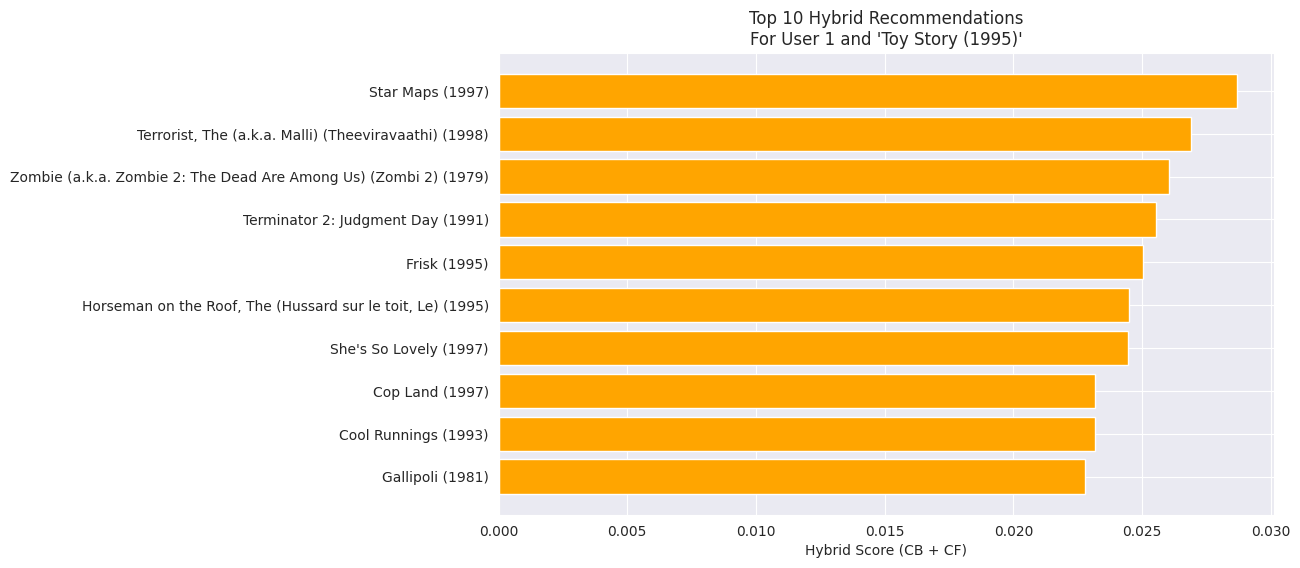

In [34]:
import matplotlib.pyplot as plt

def plot_hybrid_recommendations(recommendations, movie_title, user_id):
    plt.figure(figsize=(10,6))
    plt.barh(recommendations['title'], recommendations['hybrid_score'], color='orange')
    plt.gca().invert_yaxis()
    plt.xlabel("Hybrid Score (CB + CF)")
    plt.title(f"Top {len(recommendations)} Hybrid Recommendations\nFor User {user_id} and '{movie_title}'")
    plt.show()

plot_hybrid_recommendations(recommendations, movie, user_id)


# 🎬 Final Project Summary
1. **Dataset:** MovieLens movies2.csv + ratings.csv  
2. **Content-Based Filtering:** Uses metadata (cast, crew, genres, overview).  
3. **Collaborative Filtering:** Built with SVD for user–movie rating predictions.  
4. **Hybrid Approach:** Weighted 90% CB + 10% CF for balanced recommendations.  
5. **Deployment:** Precomputed models saved as `similarity.pkl` and `preds_df.pkl`, used in the Streamlit app.  

✅ This system provides **personalized, professional-level movie recommendations**, similar to Netflix.


#Streamlit App Code And Link

###https://movie-recommender-bvrhsdz4snvfe4xmd8hbv5.streamlit.app/

In [40]:
 # import streamlit as st
# import pandas as pd
# import numpy as np
# import pickle
# import requests
# import gdown

# #st.set_page_config(layout="wide", page_title="🎬 Movie Recommender", page_icon="🎥")

#  -----------------------------
#  1️⃣ Download from Google Drive
# -----------------------------
# @st.cache_data
# def download_from_drive(file_id, output):
#     gdown.download(
#         f"https://drive.google.com/uc?id={file_id}",
#         output,
#         quiet=False
#     )

# -----------------------------
# 2️⃣ Caching functions
# -----------------------------
# @st.cache_data
# def load_movies(file):
#     df = pd.read_csv(file)
#     if 'tags' in df.columns:
#         df['genres_list'] = df['tags'].apply(lambda x: x.split('|') if pd.notna(x) else [])
#     elif 'genres' in df.columns:
#         df['genres_list'] = df['genres'].apply(lambda x: x.split('|') if pd.notna(x) else [])
#     else:
#         df['genres_list'] = [[] for _ in range(len(df))]
#     return df

# @st.cache_data
# def load_pickle(file):
#     with open(file, 'rb') as f:
#         return pickle.load(f)

# @st.cache_data
# def fetch_poster(movie_id):
#     try:
#         url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key=8265bd1679663a7ea12ac168da84d2e8&language=en-US"
#         data = requests.get(url).json()
#         poster_path = data.get('poster_path')
#         if poster_path:
#             return "https://image.tmdb.org/t/p/w500/" + poster_path
#     except:
#         pass
#     return None

# @st.cache_data
# def fetch_trailer(movie_id):
#     try:
#         url = f"https://api.themoviedb.org/3/movie/{movie_id}/videos?api_key=8265bd1679663a7ea12ac168da84d2e8&language=en-US"
#         data = requests.get(url).json()
#         results = data.get('results', [])
#         for video in results:
#             if video['type'] == 'Trailer' and video['site'] == 'YouTube':
#                 return f"https://www.youtube.com/watch?v={video['key']}"
#     except:
#         pass
#     return None

# @st.cache_data
# def fetch_movie_details(movie_id):
#     try:
#         url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key=8265bd1679663a7ea12ac168da84d2e8&language=en-US"
#         data = requests.get(url).json()
#         return {
#             "overview": data.get('overview', ''),
#             "genres": [g['name'] for g in data.get('genres', [])],
#             "homepage": data.get('homepage', f"https://www.themoviedb.org/movie/{movie_id}"),
#             "release_date": data.get('release_date', ''),
#             "rating": data.get('vote_average', 0),
#         }
#     except:
#         return {"overview": "", "genres": [], "homepage": "", "release_date": "", "rating": 0}

# # -----------------------------
# # 3️⃣ Download big files
# # -----------------------------
# download_from_drive("1-tL3n38J8pRlEmTxYKeneYROlMkASmew", "similarity.pkl")
# download_from_drive("1PIolsTRggxPWk_8WA3NHbVKG03Ldkfke", "preds_df.pkl")

# # -----------------------------
# # 4️⃣ Load data
# # -----------------------------
# movies = load_movies("movies2.csv")
# similarity = load_pickle("similarity.pkl")
# preds_df = load_pickle("preds_df.pkl")

# # -----------------------------
# # 5️⃣ UI Header & Filters
# # -----------------------------
# st.markdown("<h1 style='text-align: center; color: #FF4B4B;'>🎬 Movie Recommender System</h1>", unsafe_allow_html=True)
# st.markdown("<p style='text-align: center;'>A hybrid recommender using Collaborative Filtering + Content Similarity</p>", unsafe_allow_html=True)
# st.write("---")

# with st.sidebar:
#     st.header("⚙️ Filters")
#     user_ids = preds_df.index.tolist()
#     selected_user = st.selectbox("👤 Select User:", user_ids)
#     selected_movie = st.selectbox("🎥 Search Movie:", movies['title'].values)
#     all_genres = sorted(set(g for gs in movies['genres_list'] for g in gs))
#     selected_genres = st.multiselect("🎭 Filter by genres:", all_genres)

# # -----------------------------
# # 6️⃣ Hybrid Recommendation Function
# # -----------------------------
# def hybrid_recommend(user_id, movie_title, movies_df, preds_df, similarity, top_n=10, alpha=0.1):
#     if selected_genres:
#         filtered_movies = movies_df[movies_df['genres_list'].apply(lambda g_list: any(g in g_list for g in selected_genres))]
#     else:
#         filtered_movies = movies_df

#     if movie_title not in filtered_movies['title'].values:
#         return pd.DataFrame(columns=['title', 'poster', 'hybrid_score', 'id'])

#     cf_scores_user = preds_df.loc[user_id]
#     cf_norm = (cf_scores_user - cf_scores_user.min()) / (cf_scores_user.max() - cf_scores_user.min())
#     cf_norm = cf_norm.reindex(filtered_movies.index, fill_value=0)

#     idx = filtered_movies.index[filtered_movies['title'] == movie_title][0]
#     content_norm = similarity[idx]
#     content_norm = (content_norm - content_norm.min()) / (content_norm.max() - content_norm.min())
#     content_norm = pd.Series(content_norm, index=filtered_movies.index)

#     hybrid_scores = alpha * cf_norm + (1 - alpha) * content_norm

#     top_idx = hybrid_scores.sort_values(ascending=False).head(top_n).index
#     recommendations = filtered_movies.loc[top_idx].copy()
#     recommendations['hybrid_score'] = hybrid_scores.loc[top_idx].values
#     recommendations['poster'] = recommendations['id'].apply(fetch_poster)
#     recommendations['trailer'] = recommendations['id'].apply(fetch_trailer)
#     return recommendations[['title', 'poster', 'trailer', 'hybrid_score', 'id']]

# # -----------------------------
# # 7️⃣ Trending Function
# # -----------------------------
# def trending_movies(movies_df, top_n=10):
#     trending = movies_df.sample(top_n)
#     trending['poster'] = trending['id'].apply(fetch_poster)
#     trending['trailer'] = trending['id'].apply(fetch_trailer)
#     return trending[['title', 'poster', 'trailer', 'id']]

# # -----------------------------
# # 8️⃣ Display Horizontal Scroll Row
# # -----------------------------
# def display_row(df):
#     cols = st.columns(len(df))
#     for i, col in enumerate(cols):
#         title = df['title'].iloc[i]
#         poster = df['poster'].iloc[i]
#         trailer = df['trailer'].iloc[i]
#         movie_id = df['id'].iloc[i]
#         if poster:
#             if trailer:
#                 col.markdown(f"<h4 style='text-align:center'><a href='{trailer}' target='_blank'>{title}</a></h4>", unsafe_allow_html=True)
#             else:
#                 col.markdown(f"<h4 style='text-align:center'>{title}</h4>", unsafe_allow_html=True)
#             col.image(poster, use_container_width=True)
#             details = fetch_movie_details(movie_id)
#             if details['overview']:
#                 col.caption(details['overview'][:120] + "...")

# # -----------------------------
# # 9️⃣ Show Hybrid Recommendations
# # -----------------------------
# st.subheader("🔥 Personalized Recommendations")
# if st.button("✨ Show Recommendations"):
#     with st.spinner("Fetching recommendations..."):
#         recs = hybrid_recommend(selected_user, selected_movie, movies, preds_df, similarity, top_n=10, alpha=0.1)
#         if recs.empty:
#             st.warning("No recommendations found!")
#         else:
#             display_row(recs)

# # -----------------------------
# # 🔟 Trending Row
# # -----------------------------
# st.subheader("🌟 Trending Now")
# trending = trending_movies(movies, top_n=10)
# display_row(trending)

# # -----------------------------
# # 1️⃣1️⃣ Watch History Simulation
# # -----------------------------
# st.subheader("🎥 Based on Your Watch History")
# watched_movies = movies.sample(10)
# watched_movies['poster'] = watched_movies['id'].apply(fetch_poster)
# watched_movies['trailer'] = watched_movies['id'].apply(fetch_trailer)
# display_row(watched_movies)
